<a href="https://colab.research.google.com/github/tracyxoxo/INMET-promover-experimentos-de-predic-a-o-de-temperatura/blob/dev/TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

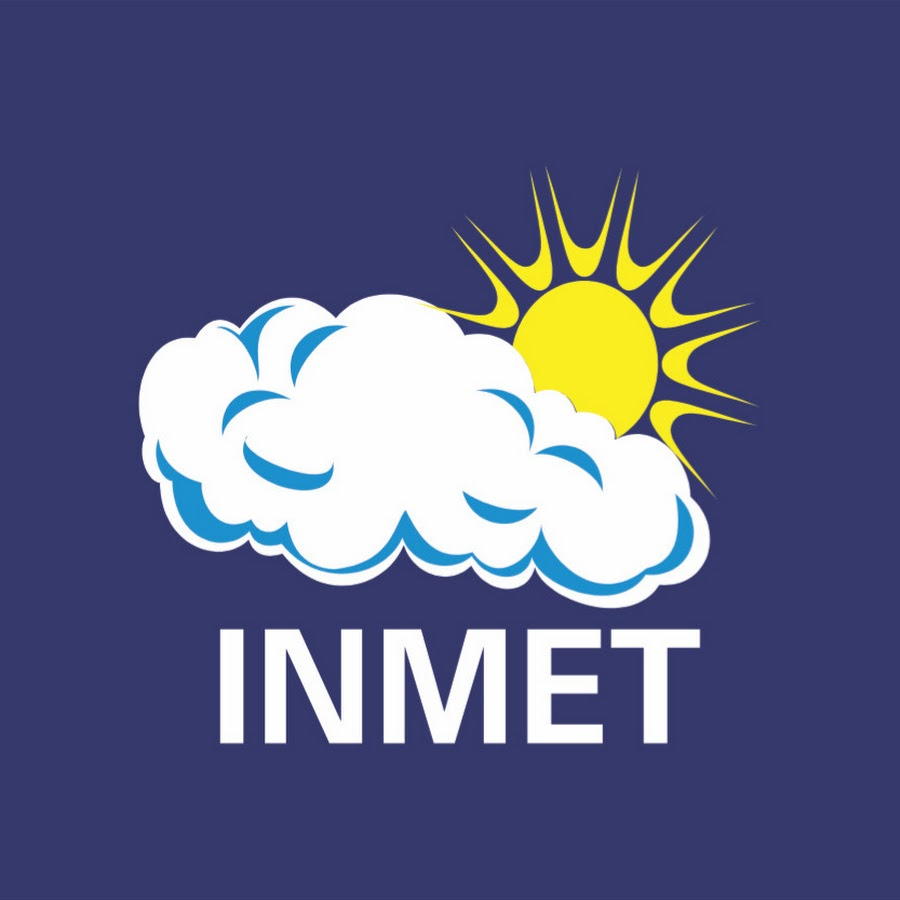
# **Usando dados do Instituto Nacional de Metereologia - INMET, promover experimentos de predição de temperatura**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from shutil import move
from utilities import extract_filtered_files,standard_hour

In [2]:
filtered_files = extract_filtered_files(
    files_path=r".\data",
    extract_path=r".\data_extracted",
    pattern='INMET_SE_SP_A705_BAURU'
)

print(filtered_files)

['.\\data_extracted_final\\2001\\2001\\INMET_SE_SP_A705_BAURU_30-08-2001_A_31-12-2001.CSV', '.\\data_extracted_final\\2002\\2002\\INMET_SE_SP_A705_BAURU_01-01-2002_A_31-12-2002.CSV', '.\\data_extracted_final\\2003\\INMET_SE_SP_A705_BAURU_01-01-2003_A_31-12-2003.CSV', '.\\data_extracted_final\\2004\\INMET_SE_SP_A705_BAURU_01-01-2004_A_31-12-2004.CSV', '.\\data_extracted_final\\2005\\INMET_SE_SP_A705_BAURU_01-01-2005_A_31-12-2005.CSV', '.\\data_extracted_final\\2006\\INMET_SE_SP_A705_BAURU_01-01-2006_A_31-12-2006.CSV', '.\\data_extracted_final\\2007\\INMET_SE_SP_A705_BAURU_01-01-2007_A_31-12-2007.CSV', '.\\data_extracted_final\\2008\\INMET_SE_SP_A705_BAURU_01-01-2008_A_31-12-2008.CSV', '.\\data_extracted_final\\2009\\INMET_SE_SP_A705_BAURU_01-01-2009_A_31-12-2009.CSV', '.\\data_extracted_final\\2010\\INMET_SE_SP_A705_BAURU_01-01-2010_A_31-12-2010.CSV', '.\\data_extracted_final\\2011\\INMET_SE_SP_A705_BAURU_01-01-2011_A_31-12-2011.CSV', '.\\data_extracted_final\\2012\\2012\\INMET_SE_SP_A7

#### **Processando dados dos diferentes anos disponíveis no website do INMET (2000 - 2025)**

In [3]:
df_list = []

files = filtered_files

for file in files:
    df = pd.read_csv(file, encoding="ISO-8859-1", sep=";", skiprows=8, header=0)
    df = df.rename(columns={
        'DATA (YYYY-MM-DD)': 'Data',
        'HORA (UTC)' : 'Hora UTC'
    })

    df_list.append(df)
    general_df = pd.concat(df_list, ignore_index=True)

general_df

,Data,Hora UTC,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),...,TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",Unnamed: 19,RADIACAO GLOBAL (Kj/m²)
0,2001-08-30,00:00,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,-9999,-9999,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,NaN,NaN
1,2001-08-30,01:00,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,-9999,-9999,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,NaN,NaN
2,2001-08-30,02:00,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,-9999,-9999,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,NaN,NaN
3,2001-08-30,03:00,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,-9999,-9999,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,NaN,NaN
4,2001-08-30,04:00,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,-9999,-9999,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206011,2025/02/28,1900 UTC,0,"941,5","942,6","941,5",NaN,"33,8","16,1","34,2",...,"20,1","15,3",52.0,33.0,35.0,76.0,"4,6","1,8",NaN,NaN
206012,2025/02/28,2000 UTC,0,"940,9","941,5","940,8",NaN,33,"16,3",34,...,"20,5","16,1",57.0,35.0,37.0,109.0,"4,4",",4",NaN,NaN
206013,2025/02/28,2100 UTC,0,"940,9",941,"940,6",NaN,"30,1","17,8","33,7",...,18,16,48.0,35.0,48.0,82.0,"7,1","3,2",NaN,NaN
206014,2025/02/28,2200 UTC,0,941,941,"940,6",NaN,"28,1","18,1","30,1",...,"18,7","17,9",56.0,48.0,55.0,90.0,"7,1",1,NaN,"47,7"


In [4]:
general_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206016 entries, 0 to 206015
Data columns (total 21 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   Data                                                   206016 non-null  object 
 1   Hora UTC                                               206016 non-null  object 
 2   PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                       204825 non-null  object 
 3   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  204665 non-null  object 
 4   PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)        204438 non-null  object 
 5   PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)       204438 non-null  object 
 6   RADIACAO GLOBAL (KJ/m²)                                156716 non-null  object 
 7   TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)           204810 non-null  object 
 8   TEMPERATURA DO PONTO DE ORVALHO (°

In [5]:
general_df.drop(['Unnamed: 19'], axis=1, inplace=True)

general_df

,Data,Hora UTC,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",RADIACAO GLOBAL (Kj/m²)
0,2001-08-30,00:00,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,NaN
1,2001-08-30,01:00,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,NaN
2,2001-08-30,02:00,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,NaN
3,2001-08-30,03:00,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,NaN
4,2001-08-30,04:00,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206011,2025/02/28,1900 UTC,0,"941,5","942,6","941,5",NaN,"33,8","16,1","34,2","31,3","20,1","15,3",52.0,33.0,35.0,76.0,"4,6","1,8",NaN
206012,2025/02/28,2000 UTC,0,"940,9","941,5","940,8",NaN,33,"16,3",34,"29,9","20,5","16,1",57.0,35.0,37.0,109.0,"4,4",",4",NaN
206013,2025/02/28,2100 UTC,0,"940,9",941,"940,6",NaN,"30,1","17,8","33,7","30,1",18,16,48.0,35.0,48.0,82.0,"7,1","3,2",NaN
206014,2025/02/28,2200 UTC,0,941,941,"940,6",NaN,"28,1","18,1","30,1","28,1","18,7","17,9",56.0,48.0,55.0,90.0,"7,1",1,"47,7"


## Descrição das colunas
**PRECIPITAÇÃO TOTAL, HORÁRIO (mm)** – Quantidade total de chuva acumulada em um intervalo de uma hora, medida em milímetros (mm).    

**PRESSÃO ATMOSFÉRICA AO NÍVEL DA ESTAÇÃO, HORÁRIA (mB)** – Pressão atmosférica medida no local da estação meteorológica em milibares (mB).  

**PRESSÃO ATMOSFÉRICA NA HORA ANT. (AUT) (mB)** – Valor da pressão atmosférica registrado na hora anterior.    

**RADIAÇÃO GLOBAL (Kj/m²)** – Quantidade total de energia solar recebida por metro quadrado de superfície em uma hora, medida em kilojoules por metro quadrado (Kj/m²).    

**TEMPERATURA DO AR - BULBO SECO, HORÁRIA (°C)** – Temperatura do ar medida por um termômetro comum (sem influência da umidade), expressa em graus Celsius (°C).  

**TEMPERATURA DO PONTO DE ORVALHO (°C)** – Temperatura na qual o ar se torna saturado de umidade e ocorre a condensação, formando orvalho.  

**TEMPERATURA NA HORA ANT. (AUT) (°C)** – Temperatura do ar registrada na hora anterior.  

**TEMPERATURA ORVALHO NA HORA ANT. (AUT) (°C)** – Temperatura do ponto de orvalho registrada na hora anterior.  

**UMIDADE REL. NA HORA ANT. (AUT) (%)** – Umidade relativa do ar registrada na hora anterior.  

**UMIDADE RELATIVA DO AR, HORÁRIA (%)** – Quantidade de vapor d'água presente no ar em relação à quantidade máxima que ele pode conter a uma determinada temperatura, expressa em porcentagem.  

**VENTO, DIREÇÃO HORÁRIA (gr) (° (gr))** – Direção média do vento ao longo da última hora, medida em graus (°) em relação ao norte.  

**VENTO, RAJADA MÁXIMA (m/s)** – Maior velocidade do vento em um curto intervalo de tempo dentro da última hora, medida em metros por segundo (m/s).  

**VENTO, VELOCIDADE HORÁRIA (m/s)** – Velocidade média do vento ao longo da última hora, medida em metros por segundo (m/s).



# Data Type conversion

In [6]:
#general_df = backup_df

general_df['Data'] = general_df['Data'].str.replace('-','/')
general_df['Data'] = pd.to_datetime(general_df['Data'])

general_df['Hora UTC'] = general_df['Hora UTC'].apply(standard_hour)
general_df['Hora UTC'] = pd.to_datetime(general_df['Hora UTC'], format='%H%M').dt.time

general_df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'] = general_df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'].str.replace(',', '.')
general_df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'] = general_df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'].astype(float)

general_df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'] = general_df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].str.replace(',', '.')
general_df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'] = general_df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].astype(float)

general_df['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)'] = general_df['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)'].str.replace(',', '.')
general_df['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)'] = general_df['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)'].astype(float)

general_df['PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)'] = general_df['PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)'].str.replace(',','.')
general_df['PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)'] = general_df['PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)'].astype(float)

general_df['PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)'] = general_df['PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)'].str.replace(',','.')
general_df['PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)'] = general_df['PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)'].astype(float)

general_df['RADIACAO GLOBAL (Kj/m²)'] = general_df['RADIACAO GLOBAL (Kj/m²)'].str.replace(',','.')
general_df['RADIACAO GLOBAL (Kj/m²)'] = general_df['RADIACAO GLOBAL (Kj/m²)'].astype(float)

general_df['TEMPERATURA DO PONTO DE ORVALHO (°C)'] = general_df['TEMPERATURA DO PONTO DE ORVALHO (°C)'].str.replace(',','.')
general_df['TEMPERATURA DO PONTO DE ORVALHO (°C)'] = general_df['TEMPERATURA DO PONTO DE ORVALHO (°C)'].astype(float)

general_df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'] = general_df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].str.replace(',','.')
general_df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'] = general_df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].astype(float)

general_df['TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)'] = general_df['TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)'].str.replace(',','.')
general_df['TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)'] = general_df['TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)'].astype(float)

general_df['TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)'] = general_df['TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)'].str.replace(',','.')
general_df['TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)'] = general_df['TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)'].astype(float)

general_df['TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)'] = general_df['TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)'].str.replace(',','.')
general_df['TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)'] = general_df['TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)'].astype(float)

general_df['VENTO, RAJADA MAXIMA (m/s)'] = general_df['VENTO, DIREÇÃO HORARIA (gr) (° (gr))'].astype(float)

general_df['VENTO, VELOCIDADE HORARIA (m/s)'] = general_df['VENTO, VELOCIDADE HORARIA (m/s)'].str.replace(',','.')
general_df['VENTO, VELOCIDADE HORARIA (m/s)'] = general_df['VENTO, VELOCIDADE HORARIA (m/s)'].astype(float)

In [7]:
general_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206016 entries, 0 to 206015
Data columns (total 20 columns):
 #   Column                                                 Non-Null Count   Dtype         
---  ------                                                 --------------   -----         
 0   Data                                                   206016 non-null  datetime64[ns]
 1   Hora UTC                                               206016 non-null  object        
 2   PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                       204825 non-null  float64       
 3   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  204665 non-null  float64       
 4   PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)        204438 non-null  float64       
 5   PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)       204438 non-null  float64       
 6   RADIACAO GLOBAL (KJ/m²)                                156716 non-null  object        
 7   TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)           2

In [9]:
general_df

,Data,Hora UTC,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",RADIACAO GLOBAL (Kj/m²)
0,2001-08-30,00:00:00,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,NaN
1,2001-08-30,01:00:00,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,NaN
2,2001-08-30,02:00:00,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,NaN
3,2001-08-30,03:00:00,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,NaN
4,2001-08-30,04:00:00,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206011,2025-02-28,19:00:00,0.0,941.5,942.6,941.5,NaN,33.8,16.1,34.2,31.3,20.1,15.3,52.0,33.0,35.0,76.0,76.0,1.8,NaN
206012,2025-02-28,20:00:00,0.0,940.9,941.5,940.8,NaN,33.0,16.3,34.0,29.9,20.5,16.1,57.0,35.0,37.0,109.0,109.0,0.4,NaN
206013,2025-02-28,21:00:00,0.0,940.9,941.0,940.6,NaN,30.1,17.8,33.7,30.1,18.0,16.0,48.0,35.0,48.0,82.0,82.0,3.2,NaN
206014,2025-02-28,22:00:00,0.0,941.0,941.0,940.6,NaN,28.1,18.1,30.1,28.1,18.7,17.9,56.0,48.0,55.0,90.0,90.0,1.0,47.7


In [11]:
general_df.describe()

,Data,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",RADIACAO GLOBAL (Kj/m²)
count,206016,204825.000000,204665.000000,204438.000000,204438.000000,204810.000000,198489.000000,204438.000000,204438.000000,197846.000000,197846.000000,197877.000000,197877.000000,198489.000000,204440.000000,204440.000000,204440.000000,26584.000000
mean,2013-05-30 12:00:00,-1046.954331,-149.659487,-153.252538,-153.721879,-977.419793,-1126.461784,-980.123023,-981.323310,-1136.357295,-1137.256498,-1085.017329,-1090.601318,-1078.020031,-870.214063,-870.214063,-1012.347488,1176.087496
min,2001-08-30 00:00:00,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,0.000000
25%,2007-07-15 18:00:00,0.000000,939.800000,940.100000,939.600000,17.200000,10.900000,17.700000,16.800000,11.400000,10.400000,52.000000,43.000000,48.000000,60.000000,60.000000,0.200000,261.750000
50%,2013-05-30 12:00:00,0.000000,942.500000,942.800000,942.300000,20.900000,15.200000,21.300000,20.400000,15.700000,14.800000,73.000000,65.000000,69.000000,114.000000,114.000000,1.200000,1084.100000
75%,2019-04-15 06:00:00,0.000000,945.200000,945.500000,945.000000,24.700000,18.600000,25.500000,23.800000,19.100000,18.100000,88.000000,82.000000,85.000000,233.000000,233.000000,2.000000,1814.700000
max,2025-02-28 00:00:00,55.600000,956.500000,963.800000,956.400000,41.000000,28.000000,41.600000,40.400000,29.100000,26.200000,100.000000,100.000000,100.000000,360.000000,360.000000,10.200000,4163.600000
std,NaN,3061.650800,3280.850171,3286.044301,3285.887693,3002.552770,3183.117030,3007.136934,3006.817829,3195.795554,3195.471376,3213.192433,3211.347882,3200.547487,3067.998299,3067.998299,3018.299509,964.338439


PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                            Axes(0.125,0.11;0.0383663x0.77)
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)     Axes(0.17104,0.11;0.0383663x0.77)
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)          Axes(0.217079,0.11;0.0383663x0.77)
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)         Axes(0.263119,0.11;0.0383663x0.77)
TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)             Axes(0.309158,0.11;0.0383663x0.77)
TEMPERATURA DO PONTO DE ORVALHO (°C)                     Axes(0.355198,0.11;0.0383663x0.77)
TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)               Axes(0.401238,0.11;0.0383663x0.77)
TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)               Axes(0.447277,0.11;0.0383663x0.77)
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)         Axes(0.493317,0.11;0.0383663x0.77)
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)         Axes(0.539356,0.11;0.0383663x0.77)
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                 Axes(0.585396,0.11;0.03

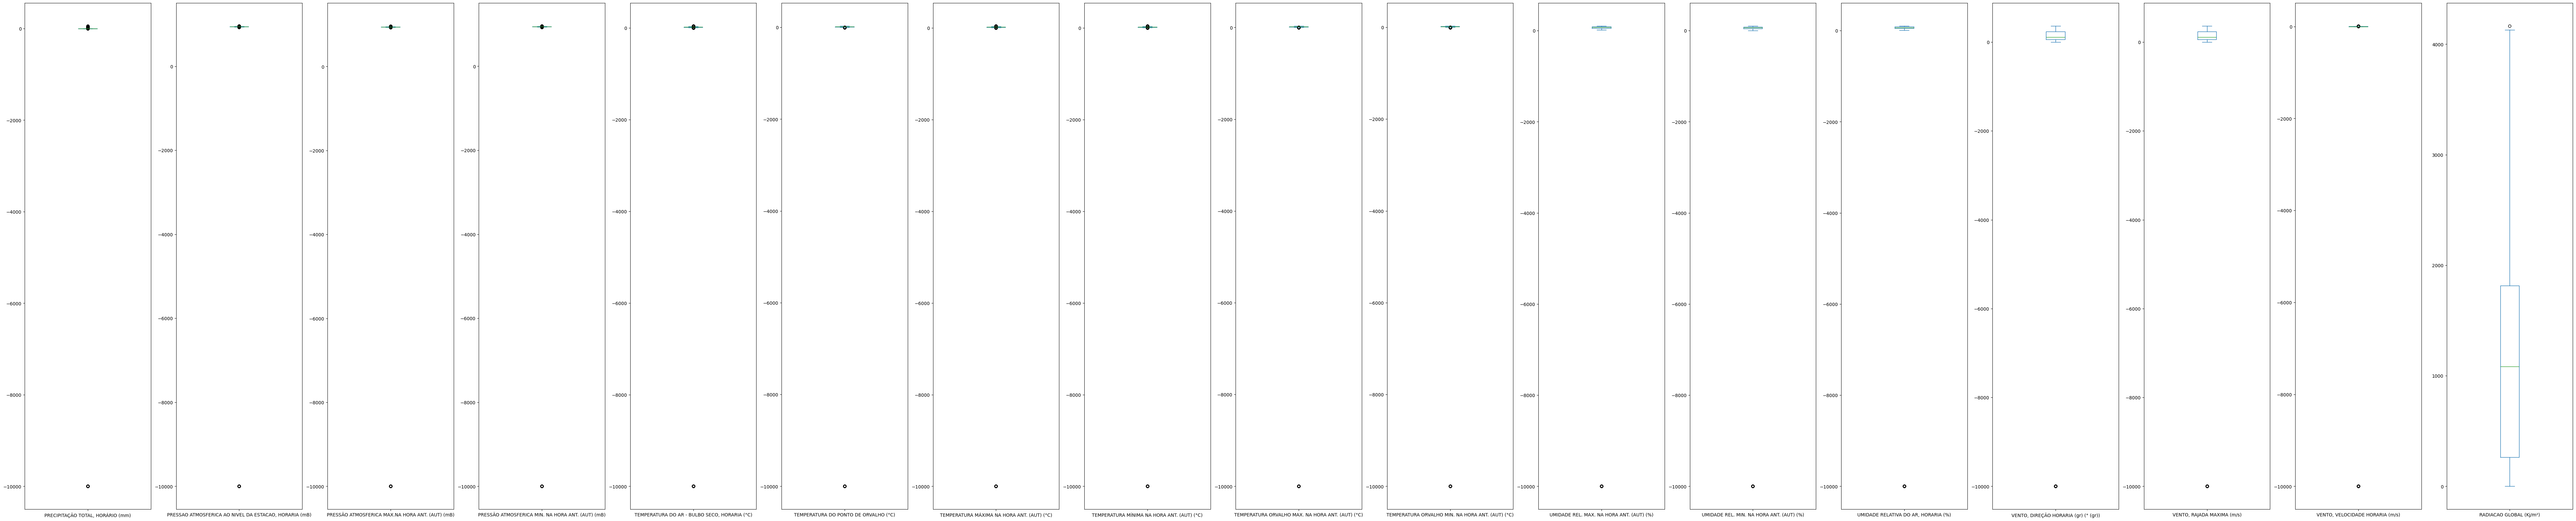

In [12]:
general_df.plot(kind='box',figsize=(100,20), subplots=True)

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['datetime'], df['temperature'], color='blue')
plt.title("Temperature Over Time")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.tight_layout()

